In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytassim
from pytassim.assimilation import LETKFilter, ETKFilter
from pytassim.localization import GaspariCohn
from pytassim.model import Lorenz96
from pytassim.model.forward_model import forward_model
from pytassim.model.integration import RK4Integrator
from pytassim.generator import observation_generator
from pytassim.obs_ops.identity import IdentityOperator

from datasets import Lorenz96AssimDataset

import numpy as np
import xarray as xr
import torch

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

import logging

In [3]:
rnd = np.random.RandomState(1)

# Create data

In [51]:
obs_operator = IdentityOperator(obs_points=np.arange(0, 40, 5), random_state=rnd)
ds = Lorenz96AssimDataset(rnd, end_days=200, rnd_kwargs={'scale': 0.5}, obs_var=0.5**2, obs_operator=obs_operator)

100%|██████████| 4801/4801 [00:01<00:00, 3070.20it/s]


# Assimilation model, including localization

In [52]:
def l96_distance(a, b):
    abs_dist = np.abs(a-b)
    dist = np.minimum(abs_dist, 40-abs_dist)
    return dist

In [53]:
gaspari_cohn = GaspariCohn(length_scale=5, dist_func=l96_distance)

In [54]:
letkf = LETKFilter(localization=gaspari_cohn, inf_factor=1.1, gpu=False)

# Set up ensemble

In [55]:
ens_size = 50

# Lets say that the ensemble forcing has a little bias and a pertubation of roundabout 6%
ens_f = torch.tensor(rnd.normal(0, 0.5, size=(1, ens_size, 1)) + ds.forcing)

# Intialize the ensemble model and the integrator
l96_ensemble = Lorenz96(ens_f)
ensemble_integrator = RK4Integrator(l96_ensemble, dt=ds.dt)

In [56]:
# Perturbations of the ensemble initial state are roundabout 10 % of the interspatial variability of VR1
ens_pert_std = 0.3

# We want to start every fifth day of VR1 a new ensemble run
ens_ana_time = ds.dt_obs

# Our forecast time is five days to get the same amount of samples as in VR1
ens_lead_time = 5

ens_fcst_steps = np.arange(0, ens_lead_time, ds.dt_days)

In [57]:
start_state = ds.ds_vr1.isel(time=0)

In [58]:
ens_start_pert = rnd.normal(0, 0.5, size=(1, ens_size, ds.nr_grids))
ens_start_state = xr.DataArray(
    data = ens_start_pert,
    coords = dict(
        var_name=['x', ],
        grid=np.arange(ds.nr_grids),
        ensemble=np.arange(ens_size)
    ),
    dims = ['var_name', 'ensemble', 'grid',]
)
ens_start_state = ens_start_state + ds.ds_vr1.isel(time=0, ensemble=0)

# Assimilation with the LETKF

In [59]:
p_bar = tqdm_notebook(total=len(ds))

In [60]:
zero_data = np.zeros((1, len(ds.ds_obs.time.values), len(ens_fcst_steps), ens_size, ds.nr_grids))
letkf_forecasts = xr.DataArray(
    data=zero_data,
    coords={
        'var_name': ens_start_state.var_name.values,
        'analysis': ds.ds_obs.time.values,
        'time': ens_fcst_steps,
        'ensemble': ens_start_state.ensemble.values,
        'grid': ens_start_state.grid.values,
    },
    dims=['var_name', 'analysis', 'time', 'ensemble', 'grid']
)

In [61]:
%%capture
first_guess = None
latest_state = ens_start_state
for obs in ds:
    if first_guess is not None:
        analysis = letkf.assimilate(
            first_guess, obs, analysis_time=obs.time.values
        )
        latest_state = analysis.squeeze(dim='var_name')
    ensemble_forecast = forward_model(
        ens_fcst_steps, 0,
        torch.tensor(latest_state.values),
        ensemble_integrator,
    )
    letkf_forecasts.loc[dict(analysis=obs.time.values)] = ensemble_forecast
    first_guess = ensemble_forecast.sel(
        time=[ens_ana_time,], drop=False
    )
    first_guess['time'] += obs.time.values
    p_bar.update()

In [62]:
stacked_forecasts = letkf_forecasts.stack(stacked=['analysis', 'time'])
stacked_forecasts['validtime'] = stacked_forecasts['analysis'] + stacked_forecasts['time']

In [63]:
intersect_time = [True if t in ds.ds_vr1.time.values else False for t in stacked_forecasts['validtime'].values]
stacked_forecasts_mean = stacked_forecasts.mean('ensemble').sel(stacked=intersect_time)
sliced_ds_vr1 = ds.ds_vr1.sel(time=stacked_forecasts_mean.validtime.values)
sliced_ds_vr1 = sliced_ds_vr1.rename(time='stacked')
sliced_ds_vr1['stacked'] = stacked_forecasts_mean['stacked']
sliced_ds_vr1 = sliced_ds_vr1.unstack('stacked')

In [64]:
letkf_err = (letkf_forecasts.mean('ensemble') - sliced_ds_vr1.mean('ensemble'))

/scratch/local1/anaconda3/envs/pytassim-dev/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [65]:
letkf_rmse = np.sqrt((letkf_err ** 2).mean(['analysis', 'grid'])).squeeze()
letkf_bias = letkf_err.mean(['analysis', 'grid']).squeeze()
letkf_std = letkf_forecasts.std('ensemble').mean(['analysis', 'grid']).squeeze()

In [66]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

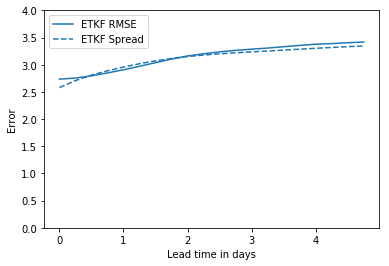

In [67]:
fig, ax = plt.subplots()
ax.plot(letkf_err['time'], letkf_rmse, label='ETKF RMSE', c=color_cycle[0])
ax.plot(letkf_err['time'], letkf_std, label='ETKF Spread', c=color_cycle[0], ls='--')
ax.set_ylim(0, 4)
ax.set_xlabel('Lead time in days')
ax.set_ylabel('Error')
ax.legend()
plt.show()

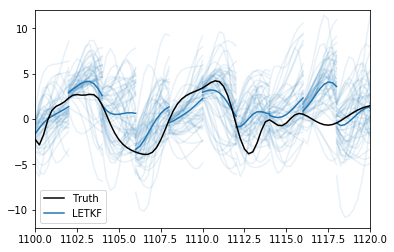

In [76]:
start_time = 1100
end_time = 1120

plot_forecasts = letkf_forecasts.isel(time=slice(0, 9)).sel(analysis=slice(start_time, end_time), grid=10)
plot_vr1 = ds.ds_vr1.sel(time=slice(start_time, end_time+5), grid=10)

def plot_member(fcst_mem, ax, *args, **kwargs):
    for analysis in fcst_mem.analysis.values:
        validtime = fcst_mem['time'] + analysis
        mem_plot = ax.plot(validtime, fcst_mem.sel(analysis=analysis).squeeze(), *args, **kwargs)
    return mem_plot

fig, ax = plt.subplots()
_ = plot_member(plot_forecasts, ax, c=color_cycle[0], alpha=0.1)
plt_letkf, = plot_member(plot_forecasts.mean('ensemble'), ax, label='LETKF', c=color_cycle[0])
plt_truth, = ax.plot(plot_vr1['time'], plot_vr1.squeeze(), c='black')
ax.set_ylim(-12, 12)
ax.set_xlim(start_time, end_time)
ax.legend([plt_truth, plt_letkf], ['Truth', 'LETKF'])
plt.show()